<a href="https://colab.research.google.com/github/Audrey-Stuart0/Text-Analysis-Project/blob/main/TextAnalysisProject_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Course Project




#Part 1 and Part 2 (Descriptive Analysis/exploritory questions)

---




## <a name="Top"></a> Table of Contents

1. [Load the dataset](#1)
2. [Distribution of Spam vs Not Spam (HAM)](#2)<br>
3. [Length of Messages](#3)<br>
4. [Word Count Distribution](#4)<br>
5. [Most Common Words](#5)<br>
6. [Summary Statistics](#6)<br>



###<a name=1></a> 1. Load the dataset

In [ ]:
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Display the first few rows
print(df.head())

#Making sure warning errors dont print:
import warnings
import logging
from transformers import logging as hf_logging

# Suppress warnings
warnings.filterwarnings('ignore')

# Suppress Hugging Face logs
hf_logging.set_verbosity_error()

# Optional: Suppress Python logging output from libraries
logging.getLogger().setLevel(logging.ERROR)

# Suppress tqdm progress bars globally
from tqdm import tqdm
tqdm.disable = True



  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### 2.Text Preprocessing


In [ ]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
import re
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np
import kagglehub
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Install vaderSentiment if not already installed
!pip install vaderSentiment

# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

#custom the dictionary to remove the stopword
custom_stopwords = {'ur','txt','u','get','the','is','a','got','U','gt','call','Call','Text','text'}
combined_stopwords = stop_words.union(custom_stopwords)

# Preprocess tweets: Tokenize and remove stopwords/punctuation/special characters
def remove_html_tags(text):
    """
    Removes HTML tags from the given text.
    Args:
        text (str): Text containing HTML tags.
    Returns:
        str: Cleaned text with HTML tags removed.
    """
    return re.sub(r'<.*?>', '', text)
def remove_extra_spaces(text):
    # First, strip leading and trailing spaces
    text = text.strip()
    # Then, split and join words to remove extra spaces between them
    return " ".join(text.split())

def preprocess_text(text):
    # Remove HTML tags
    no_html_text = remove_html_tags(text)

    # Remove extra spaces
    no_space_text = remove_extra_spaces(no_html_text)

    # Tokenize text
    tokens = word_tokenize(no_space_text.lower())

    # Remove punctuation and stopwords
    tokens = [t for t in tokens if t.isalnum() and t not in combined_stopwords]

    # Remove mentions
    text = re.sub(r'@\w+', '', text.lower())

    # Remove webpages
    text = re.sub(r'http\S+', "", text)

    # Tokenize and remove non-alphabetic words
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [word.lower() for word in tokens if word.isalpha()]

    return " ".join(cleaned_tokens)

#apply preprocesing to the message column
df['cleaned_message'] = df['message'].apply(preprocess_text)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


###Exploritory question: Are there more spam or ham messages?

<ipython-input-3-0ebf93707ee8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


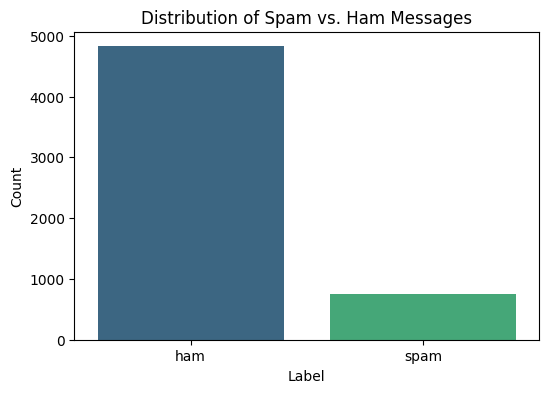

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of spam vs. ham
label_counts = df['label'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Spam vs. Ham Messages")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Exploritory question: What are the average length of messages for spam vs ham?

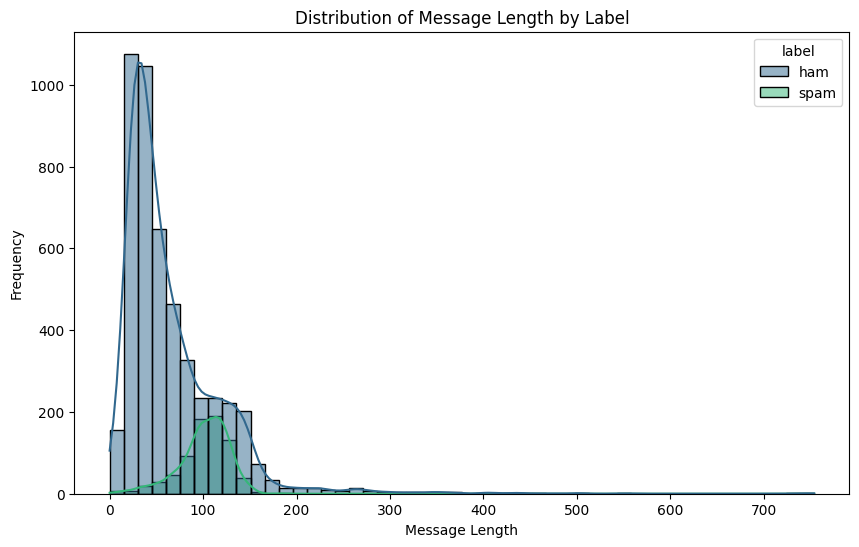

In [ ]:
# Add a column for message length
df['message_length'] = df['cleaned_message'].apply(len)

# Plot message length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True, palette="viridis")
plt.title("Distribution of Message Length by Label")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()

### Exploritory question: do spam or ham messages have more words on average?

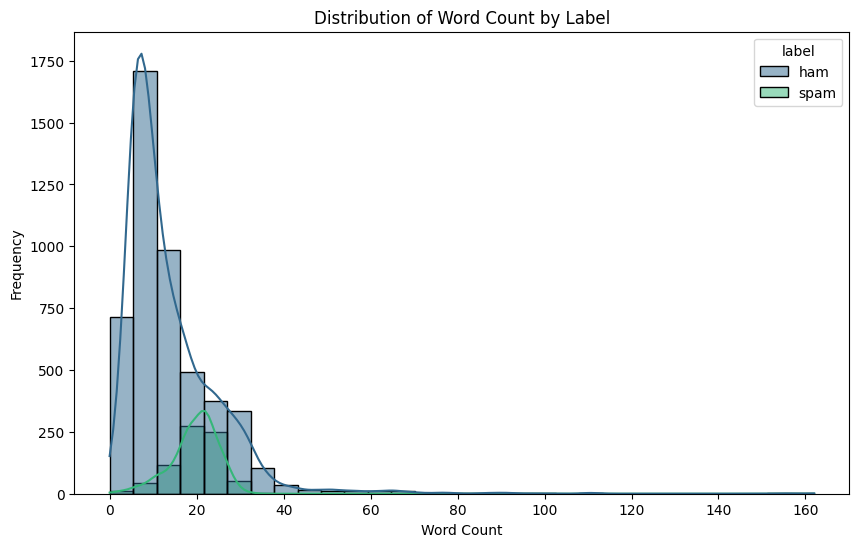

In [ ]:
# Add a column for word count
df['word_count'] = df['cleaned_message'].apply(lambda x: len(x.split()))

# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='label', bins=30, kde=True, palette="viridis")
plt.title("Distribution of Word Count by Label")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

###Exploritory Question: Is there a difference in punctuation and sentence length for spam vs not spam.

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

def analyze_message(df):
    # Download necessary NLTK resources if not already present
    nltk.download('punkt', quiet=True)

    def calculate_avg_sentence_length(text):
        sentences = sent_tokenize(text)
        if not sentences:
            return 0  # Handle empty texts to avoid ZeroDivisionError
        return sum(len(word_tokenize(sentence)) for sentence in sentences) / len(sentences)

    def count_punctuation(text):
      return sum(1 for char in text if char in string.punctuation)

    # Apply function to calculate average sentence length and punctuation count to the DataFrame
    df['avg sentence length'] = df['message'].apply(calculate_avg_sentence_length)
    df['punctuation count'] = df['message'].apply(count_punctuation)

    # Group by label and calculate the mean
    grouped_data = df.groupby('label').agg({'avg sentence length': 'mean', 'punctuation count': 'mean'}).reset_index()

    # Rename columns
    grouped_data.columns = ['label', 'avg sentence length', 'punctuation count']
    return grouped_data

#Example Usage (assuming df is your DataFrame)
result_df = analyze_message(df)
result_df


,label,avg sentence length,punctuation count
0,ham,10.432450,3.939896
1,spam,11.767185,5.712182


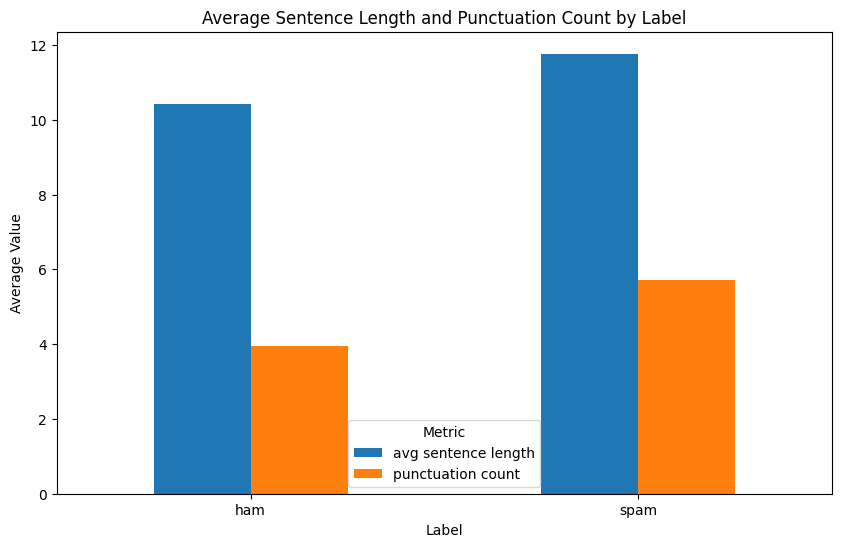

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
result_df.plot(x='label', y=['avg sentence length', 'punctuation count'], kind='bar', ax=plt.gca())
plt.title('Average Sentence Length and Punctuation Count by Label')
plt.ylabel('Average Value')
plt.xlabel('Label')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Metric')
plt.show()


### Exploritory question: What are the most common words for spam and ham?

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-6-81cd8577b455>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in spam_words], y=[word[0] for word in spam_words], ax=axes[0], palette="viridis")


Top 10 Spam Words: [('free', 219), ('mobile', 123), ('stop', 118), ('claim', 113), ('reply', 104), ('prize', 92), ('send', 69), ('new', 69), ('nokia', 65), ('urgent', 63)]
Top 10 Ham Words: [('lt', 316), ('go', 251), ('ok', 246), ('know', 237), ('like', 233), ('good', 231), ('come', 230), ('time', 198), ('love', 197), ('day', 191)]


<ipython-input-6-81cd8577b455>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in ham_words], y=[word[0] for word in ham_words], ax=axes[1], palette="viridis")


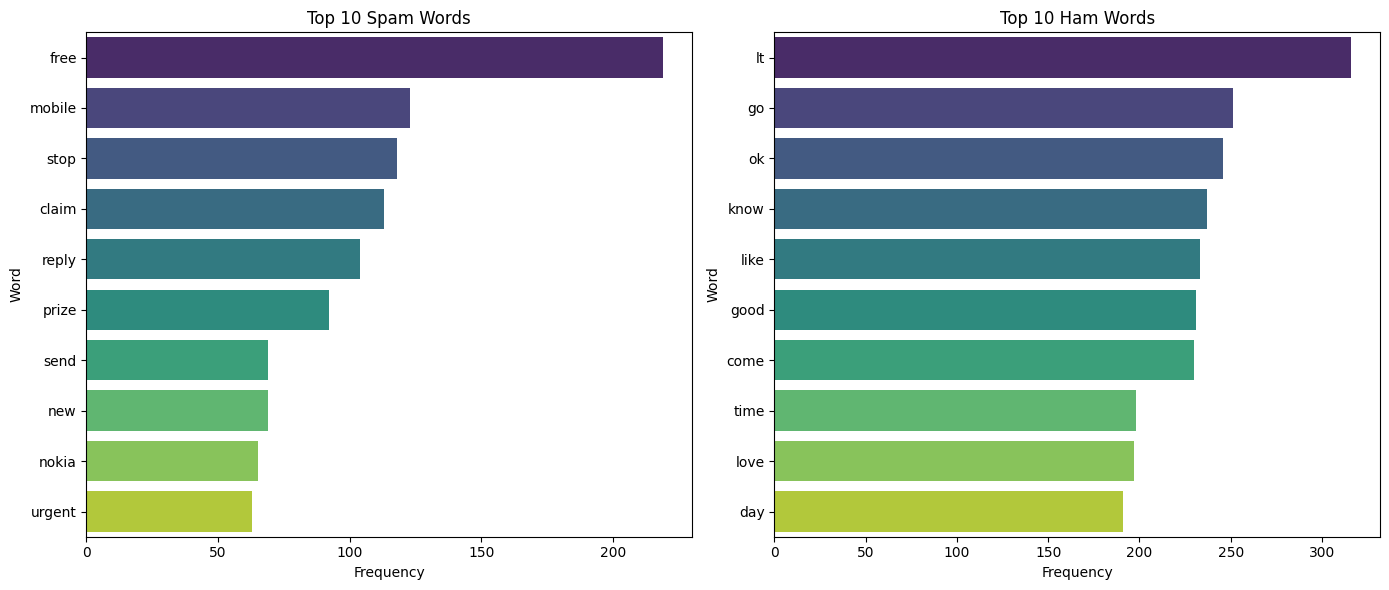

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to get most common words
def get_most_common_words(texts, n=10):
    words = " ".join(texts).split()
    words = [word for word in words if word.lower() not in combined_stopwords and word.isalpha()]
    return Counter(words).most_common(n)

# Most common words in spam
spam_words = get_most_common_words(df[df['label'] == 'spam']['cleaned_message'])
print("Top 10 Spam Words:", spam_words)

# Most common words in ham
ham_words = get_most_common_words(df[df['label'] == 'ham']['cleaned_message'])
print("Top 10 Ham Words:", ham_words)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Spam words
sns.barplot(x=[word[1] for word in spam_words], y=[word[0] for word in spam_words], ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 Spam Words")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Word")

# Ham words
sns.barplot(x=[word[1] for word in ham_words], y=[word[0] for word in ham_words], ax=axes[1], palette="viridis")
axes[1].set_title("Top 10 Ham Words")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Word")

plt.tight_layout()
plt.show()

### <a name=1></a>6.Summary Statistics

In [ ]:
# Summary statistics
summary_stats = df.groupby('label')['message_length'].describe()
print(summary_stats)

        count        mean        std  min   25%    50%    75%    max
label                                                               
ham    4825.0   65.009119  52.838288  0.0  30.0   48.0   85.0  754.0
spam    747.0  101.344043  26.501722  0.0  89.0  104.0  120.0  182.0


#Part 2 (Text mining analysis of the textual comments)

Bar Charts and Top Key Words

Top 10 Spam Words: [('free', 219), ('mobile', 123), ('stop', 118), ('claim', 113), ('reply', 104), ('prize', 92), ('send', 69), ('new', 69), ('nokia', 65), ('urgent', 63)]
Top 10 Ham Words: [('lt', 316), ('go', 251), ('ok', 246), ('know', 237), ('like', 233), ('good', 231), ('come', 230), ('time', 198), ('love', 197), ('day', 191)]


<ipython-input-8-c218c08f9280>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in spam_words], y=[word[0] for word in spam_words], ax=axes[0], palette="viridis")
<ipython-input-8-c218c08f9280>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in ham_words], y=[word[0] for word in ham_words], ax=axes[1], palette="viridis")


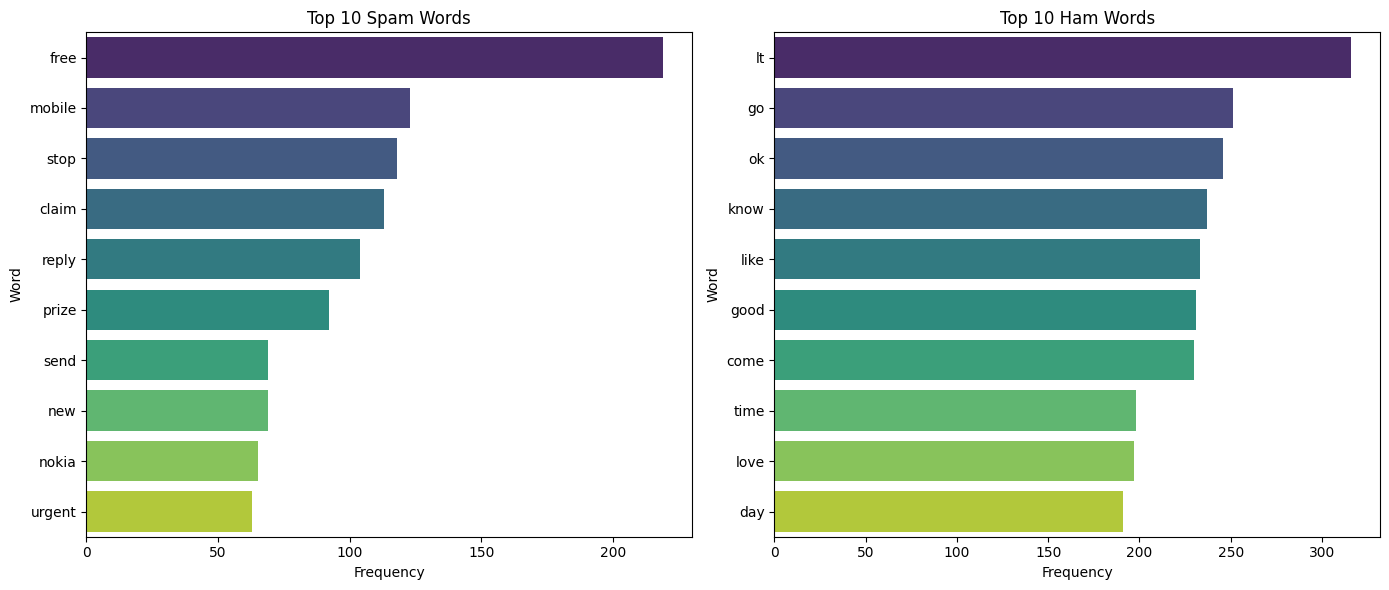

In [ ]:
# Function to get most common words
def get_most_common_words(texts, n=10):
    words = " ".join(texts).split()
    words = [word for word in words if word.lower() not in combined_stopwords and word.isalpha()]
    return Counter(words).most_common(n)
# Most common words in spam
spam_words = get_most_common_words(df[df['label'] == 'spam']['cleaned_message'])
print("Top 10 Spam Words:", spam_words)

# Most common words in ham
ham_words = get_most_common_words(df[df['label'] == 'ham']['cleaned_message'])
print("Top 10 Ham Words:", ham_words)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Spam words
sns.barplot(x=[word[1] for word in spam_words], y=[word[0] for word in spam_words], ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 Spam Words")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Word")

# Ham words
sns.barplot(x=[word[1] for word in ham_words], y=[word[0] for word in ham_words], ax=axes[1], palette="viridis")
axes[1].set_title("Top 10 Ham Words")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Word")

plt.tight_layout()
plt.show()


### Sentiment Analysis


<ipython-input-9-f776cbbf9778>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette="viridis")


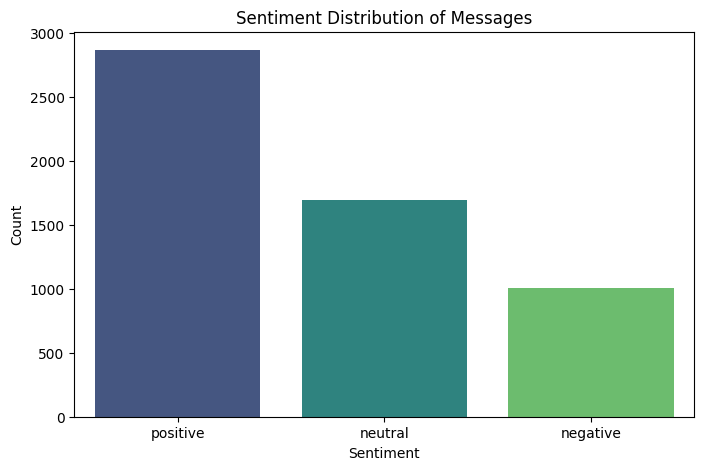

In [ ]:
# Function to get sentiment polarity using VADER
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound']

# Add sentiment column
df['sentiment'] = df['cleaned_message'].apply(get_sentiment)

# Classify sentiment as positive, negative, or neutral
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment_label', palette="viridis")
plt.title("Sentiment Distribution of Messages")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


Sentiment analysis split up for the different labels

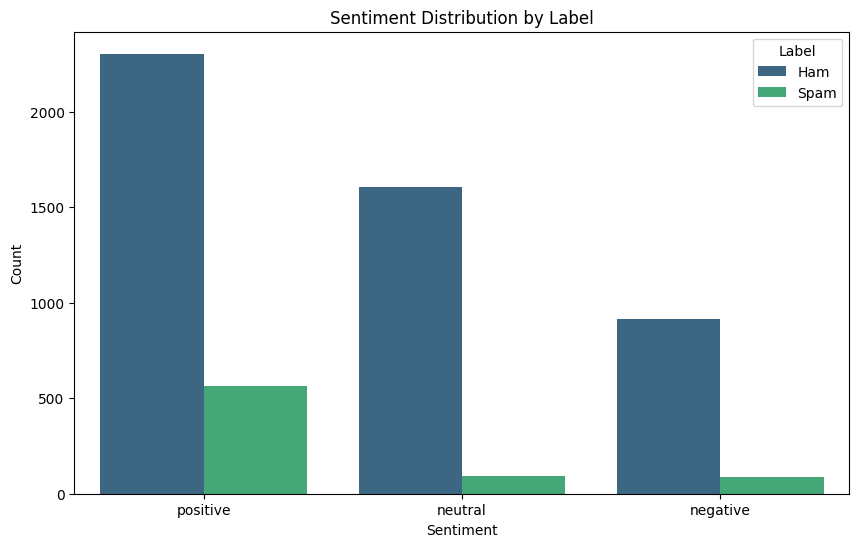

In [ ]:
# Define a mapping for labels (assuming 0 = Negative, 1 = Positive)
label_mapping = {0: "Ham", 1: "Spam"}

# Plot sentiment distribution by label
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='sentiment_label', hue='label', palette="viridis")

# Update legend labels
handles, labels = ax.get_legend_handles_labels()

#Map 'ham' to 0 and 'spam' to 1 for the legend labels
label_mapping_legend = {'ham': 0, 'spam': 1} # Create a separate mapping for legend labels
plt.legend(handles, [label_mapping.get(label_mapping_legend.get(lbl, lbl), lbl) for lbl in labels], title="Label")
# Titles and labels
plt.title("Sentiment Distribution by Label")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Show the plot
plt.show()

###Topic Modeling

In [ ]:
#import
!pip install -q gensim
!pip install -q pyLDAvis
# Gensim for topic modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel

tokenize my data

In [ ]:
# Create a list of lists, where each sublist contains the tokens of a message
data_tokens = [nltk.word_tokenize(message) for message in df['cleaned_message']]

# Create a dictionary from the data
id2word = corpora.Dictionary(data_tokens)

# Create a corpus (Term Document Frequency)
corpus = [id2word.doc2bow(text) for text in data_tokens]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.039*"gt" + 0.039*"ur" + 0.038*"lt" + 0.027*"day" + 0.019*"r" + 0.018*"today" + 0.017*"week" + 0.017*"give" + 0.017*"great" + 0.016*"well"
Topic: 1 
Words: 0.053*"to" + 0.031*"a" + 0.030*"your" + 0.028*"call" + 0.020*"now" + 0.020*"for" + 0.020*"or" + 0.016*"on" + 0.014*"from" + 0.013*"free"
Topic: 2 
Words: 0.121*"u" + 0.021*"one" + 0.020*"lor" + 0.019*"stop" + 0.017*"go" + 0.015*"n" + 0.015*"d" + 0.013*"wat" + 0.011*"ask" + 0.010*"cos"
Topic: 3 
Words: 0.043*"will" + 0.023*"then" + 0.023*"he" + 0.022*"ok" + 0.022*"time" + 0.021*"good" + 0.020*"come" + 0.016*"ü" + 0.016*"home" + 0.015*"da"
Topic: 4 
Words: 0.080*"i" + 0.058*"you" + 0.031*"the" + 0.028*"to" + 0.024*"in" + 0.023*"and" + 0.021*"it" + 0.021*"me" + 0.020*"a" + 0.019*"my"


In [ ]:
#6. Remove Stopwords, Make Bigrams
# Define functions for stopwords, bigrams, trigrams and lemmatization
from gensim.models import Phrases

def remove_stopwords(tokenized_documents):
    """
    Removes stopwords from a list of tokenized documents

    Parameters:
    tokenized_documents (list of list of str): A list where each element is a list of words from a document.
    (["token 1", "token 2"],["token 1", "token 2","token 3"])
    stop_words (set): A set of stopwords to remove.

    Returns:
    list of list of str: The input list with stopwords removed.
    """
    cleaned_documents = []  # Store documents after stopword removal

    for document in tokenized_documents:
        filtered_tokens = [word for word in simple_preprocess(str(document)) if word not in stop_words]
        cleaned_documents.append(filtered_tokens)

    return cleaned_documents


def make_bigrams(tokenzied_documents):
    # Create the bigram model
    bigram_mod = Phrases(tokenzied_documents, min_count=5, threshold=100) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram_mod) # faster way to get a sentence clubbed as a trigram/bigram
    return [bigram_mod[doc] for doc in tokenzied_documents]

def make_trigrams(tokenzied_documents):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenzied_documents]


In [ ]:
# Create data_words_list based on 'cleaned_message' column
# Assuming data_words_list should be a list of tokenized messages
data_words_list = [nltk.word_tokenize(message) for message in df['cleaned_message']]

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words_list)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

print(data_words_nostops[:2])
print(data_words_bigrams[:2])

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'oni']]
[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'oni']]


In [ ]:
#7. Create the Dictionary and Corpus needed for Topic Modeling
# Define the texts
texts = data_words_bigrams

# Create Dictionary
dictionary = corpora.Dictionary(data_words_bigrams)
print("The vocabulary is", dictionary)


# Create the corpus - the Term Document Frequency Matrix
corpus = [dictionary.doc2bow(doc) for doc in texts]

# View
print(corpus[0])
print(corpus[1])

The vocabulary is Dictionary<7240 unique tokens: ['amore', 'available', 'buffet', 'bugis', 'cine']...>
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
[(14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


In [ ]:
# Descriptive statistics for each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}")
    # Extract words and their weights from the topic
    words_weights = []
    for word_weight_pair in topic.split(" + "):
        weight, word = word_weight_pair.split("*")
        words_weights.append((word.strip('"'), float(weight)))

    # Sort words by weight in descending order
    sorted_words_weights = sorted(words_weights, key=lambda x: x[1], reverse=True)

    # Print the top words and their weights for the topic
    for word, weight in sorted_words_weights:
        print(f"  Word: {word}, Weight: {weight}")

    # Add other relevant statistics if needed
    print("-" * 20)


# Example additional statistics (you may modify or expand)

# Calculate the average topic distribution across documents
avg_topic_distribution = np.mean([lda_model.get_document_topics(doc) for doc in corpus], axis=0)
print("Average Topic Distribution:", avg_topic_distribution)

# Calculate topic coherence (a measure of how interpretable the topics are)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Topic Coherence (c_v): {coherence_lda}")

#  You can compute other measures of topic quality like  "u_mass"

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Topic Coherence (u_mass): {coherence_lda}")


Topic: 0
  Word: gt, Weight: 0.039
  Word: ur, Weight: 0.039
  Word: lt, Weight: 0.038
  Word: day, Weight: 0.027
  Word: r, Weight: 0.019
  Word: today, Weight: 0.018
  Word: week, Weight: 0.017
  Word: give, Weight: 0.017
  Word: great, Weight: 0.017
  Word: well, Weight: 0.016
--------------------
Topic: 1
  Word: to, Weight: 0.053
  Word: a, Weight: 0.031
  Word: your, Weight: 0.03
  Word: call, Weight: 0.028
  Word: now, Weight: 0.02
  Word: for, Weight: 0.02
  Word: or, Weight: 0.02
  Word: on, Weight: 0.016
  Word: from, Weight: 0.014
  Word: free, Weight: 0.013
--------------------
Topic: 2
  Word: u, Weight: 0.121
  Word: one, Weight: 0.021
  Word: lor, Weight: 0.02
  Word: stop, Weight: 0.019
  Word: go, Weight: 0.017
  Word: n, Weight: 0.015
  Word: d, Weight: 0.015
  Word: wat, Weight: 0.013
  Word: ask, Weight: 0.011
  Word: cos, Weight: 0.01
--------------------
Topic: 3
  Word: will, Weight: 0.043
  Word: then, Weight: 0.023
  Word: he, Weight: 0.023
  Word: ok, Weight: 

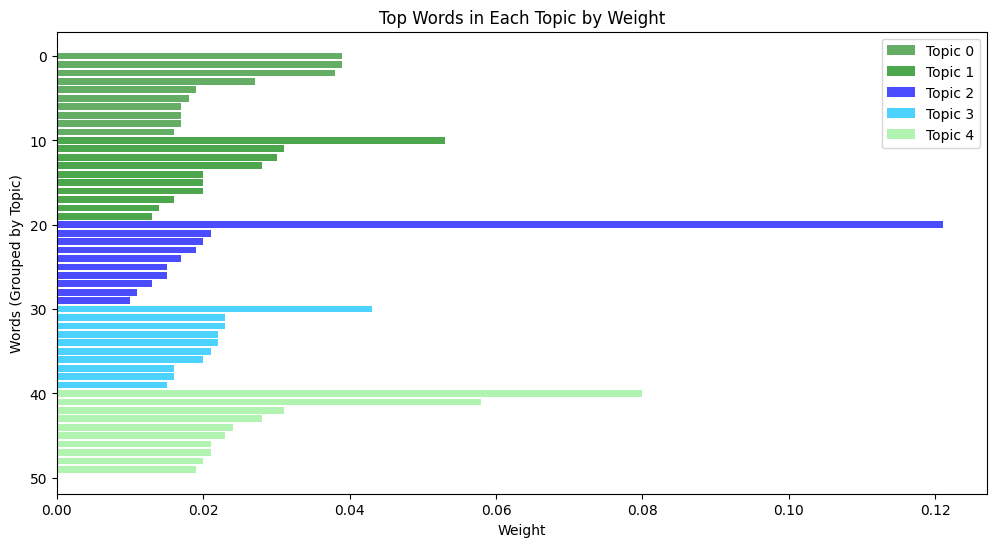

In [ ]:
# Define topic words and their weights
topics = {
    0: {"gt": 0.039, "ur": 0.039, "lt": 0.038, "day": 0.027, "r": 0.019, "today": 0.018, "week": 0.017, "give": 0.017, "great": 0.017, "well": 0.016},
    1: {"to": 0.053, "a": 0.031, "your": 0.03, "call": 0.028, "now": 0.02, "for": 0.02, "or": 0.02, "on": 0.016, "from": 0.014, "free": 0.013},
    2: {"u": 0.121, "one": 0.021, "lor": 0.02, "stop": 0.019, "go": 0.017, "n": 0.015, "d": 0.015, "wat": 0.013, "ask": 0.011, "cos": 0.01},
    3: {"will": 0.043, "then": 0.023, "he": 0.023, "ok": 0.022, "time": 0.022, "good": 0.021, "come": 0.02, "ü": 0.016, "home": 0.016, "da": 0.015},
    4: {"i": 0.08, "you": 0.058, "the": 0.031, "to": 0.028, "in": 0.024, "and": 0.023, "it": 0.021, "me": 0.021, "a": 0.02, "my": 0.019}
}

# Set figure size
plt.figure(figsize=(12, 6))

# Assign colors for each topic (correct color names)
colors = ['forestgreen', 'green', 'blue', 'deepskyblue', 'lightgreen']

# Plot each topic's top words with weights
for idx, (topic, words) in enumerate(topics.items()):
    words_list = list(words.keys())
    weights = list(words.values())
    y_pos = np.arange(len(words_list)) + idx * len(words_list)  # Offset each topic

    plt.barh(y_pos, weights, label=f"Topic {topic}", alpha=0.7, color=colors[idx])

# Add labels and legend
plt.xlabel("Weight")
plt.ylabel("Words (Grouped by Topic)")
plt.title("Top Words in Each Topic by Weight")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for readability

# Show the plot
plt.show()


### PART III: Using textual-based features from your data to predict your target variable
- we will use the BERT Advanced to train the model to see whether it is ham or spam.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
import os
import time
os.environ["WANDB_MODE"] = "disabled"

#Convert labels to binary (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


#Training & Testing the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Ensure labels are integers
train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce').astype(int)
test_df['label'] = pd.to_numeric(test_df['label'], errors='coerce').astype(int)

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(train_df['cleaned_message'].tolist())
test_encodings = tokenize_function(test_df['cleaned_message'].tolist())

#create PyTorch datset
class SMSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SMSDataset(train_encodings, train_df['label'].tolist())
test_dataset = SMSDataset(test_encodings, test_df['label'].tolist())

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    report_to=[])

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics)

# Fine-tune the model
start_time = time.time()
trainer.train()
end_time = time.time()
fine_tuning_time = end_time - start_time
print(f"Fine-tuning time for BERT Model: {fine_tuning_time:.4f} seconds")

# Evaluate the model
results = trainer.evaluate()

# Get the accuracy
accuracy = results['eval_accuracy']
print(f"Accuracy for Fine-tuned BERT Model: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.083100,0.066984,0.980269,0.980710,0.980269,0.980433
2,0.053700,0.052079,0.990135,0.990160,0.990135,0.990004
3,0.008600,0.048653,0.991031,0.991031,0.991031,0.991031


Fine-tuning time for BERT Model: 346.0020 seconds


Accuracy for Fine-tuned BERT Model: 0.9910
